### CIFAR-10 + LeNET

Observed overfitting and hence the difference between x5 and x30 i.e. different learning rate is not visible

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import accuracy_score

In [ ]:
# convert image to pixel and normalize it for faster training
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [ ]:
batch_size = 16
# loading dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
# visulaize dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


NameError: name 'make_grid' is not defined

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnnmodel = nn.Sequential(
            nn.Conv2d(3, 6, 5), # Convolution layer
            nn.ReLU(),          # Activation function
            nn.AvgPool2d(2, 2), # Pooling layer
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.fullyconn = nn.Sequential(
            nn.Linear(400, 120), # Linear Layer
            nn.ReLU(),           # ReLU Activation Function
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.cnnmodel(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconn(x)
        return x

In [ ]:
def evaluation(data, model):
    total, correct = 0, 0
    for images, labels in data:
        images = images.to('cuda:0')
        ypred = model.forward(images)
        _, predicted = torch.max(ypred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda:0')).sum().item()
    return 100 * correct / total

# train_accuracy = evaluation(trainloader, mymodel)
# test_accuracy = evaluation(testloader, mymodel)

# print(f'Train Accuracy: {train_accuracy}%')
# print(f'Test Accuracy: {test_accuracy}%')

Using device: cuda
Epoch [1/20] - Train Acc: 42.43% - Val Acc: 49.64%
Epoch [2/20] - Train Acc: 52.95% - Val Acc: 54.48%
Epoch [3/20] - Train Acc: 57.29% - Val Acc: 57.25%
Epoch [4/20] - Train Acc: 60.65% - Val Acc: 58.08%
Epoch [5/20] - Train Acc: 62.87% - Val Acc: 58.31%
Epoch [6/20] - Train Acc: 65.00% - Val Acc: 59.70%
Epoch [7/20] - Train Acc: 66.68% - Val Acc: 59.45%
Epoch [8/20] - Train Acc: 68.00% - Val Acc: 59.42%
Epoch [9/20] - Train Acc: 69.18% - Val Acc: 61.63%
Epoch [10/20] - Train Acc: 70.14% - Val Acc: 60.90%
Epoch [11/20] - Train Acc: 71.18% - Val Acc: 60.20%
Epoch [12/20] - Train Acc: 72.07% - Val Acc: 60.68%
Epoch [13/20] - Train Acc: 72.86% - Val Acc: 60.71%
Epoch [14/20] - Train Acc: 73.54% - Val Acc: 60.96%
Epoch [15/20] - Train Acc: 74.50% - Val Acc: 60.51%
Epoch [16/20] - Train Acc: 74.73% - Val Acc: 60.91%
Epoch [17/20] - Train Acc: 75.70% - Val Acc: 59.62%
Epoch [18/20] - Train Acc: 76.16% - Val Acc: 60.33%
Epoch [19/20] - Train Acc: 77.08% - Val Acc: 59.78%
Ep

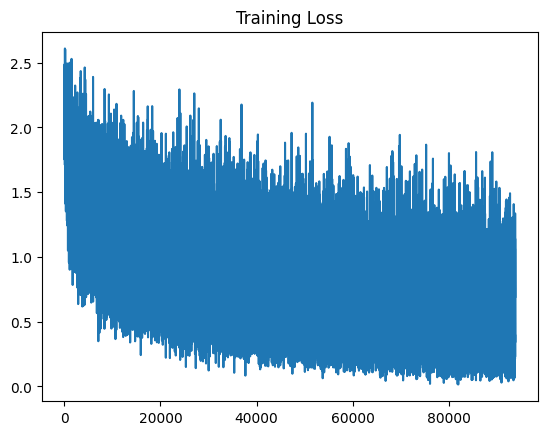

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

mymodel = LeNet().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mymodel.parameters(), lr=0.0015)

loss_arr = []

for epoch in range(30):

    # ---------------- TRAINING ----------------
    mymodel.train()
    train_correct = 0
    train_total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        ypred = mymodel(images)
        loss = loss_fn(ypred, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_arr.append(loss.item())

        # ---- Training accuracy ----
        _, predicted = torch.max(ypred, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = 100 * train_correct / train_total

    # ---------------- VALIDATION ----------------
    mymodel.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in testloader:   # or valloader if separate
            images, labels = images.to(device), labels.to(device)

            outputs = mymodel(images)
            _, predicted = torch.max(outputs, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/20] "
          f"- Train Acc: {train_acc:.2f}% "
          f"- Val Acc: {val_acc:.2f}%")

# Plot training loss
plt.plot(loss_arr)
plt.title('Training Loss')
plt.show()
